run these code block **sequentially** use shift+Enter

In [2]:
# parameter

BATCH_SIZE = 10000
EPOCHS = 2000
train_size = 300000
test_size =  100000

In [3]:
import keras
import tensorflow as tf
import csv
from sklearn.preprocessing import *
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
from matplotlib import pyplot as plt
print("Keras version " + keras.__version__)

Using TensorFlow backend.


Keras version 2.3.1


In [4]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.apply(tf.data.experimental.unbatch()).batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
#     self.axes[0].set_ylim(0, 1/self.zoom)
#     self.axes[1].set_ylim(0, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

the next part is to add train and test data,
click run and upload from local environment

In [5]:
import pandas as pd
df = pd.read_csv('repulsion_no0.csv', header=None)

# shuffle data if necessary
df = df.iloc[0:400000,:]
# df = df.sample(frac=1, axis=0).reset_index(drop=False)

num = 1e14
# # format of train/test data
# # [x y z a/b]
# # energy
train_cord = df.iloc[0:train_size, 0:4].values
train_cord = train_cord
train_label1 = df.iloc[0:train_size, 4].values * num
train_label1 = np.reshape(train_label1, (train_size, 1)) 

valid_cord = df.iloc[train_size:(train_size+test_size), 0:4].values
valid_cord = valid_cord
valid_label1 = df.iloc[train_size:(train_size+test_size),4].values * num
valid_label1 = np.reshape(valid_label1, (test_size, 1))


print(np.amin(train_label1), np.amin(valid_label1))
print(np.amax(train_label1), np.amax(valid_label1))

# count = []
# lower = int(np.amin(train_label1))
# upper = int(np.amax(train_label1))+1
# for i in range(lower,upper):
#   n = np.size(train_label1[(train_label1 < i + 0.5) & (train_label1 > i - 0.5)])
#   count.append(n)
# print(count)
# fig, ax = plt.subplots()
# ax.plot(np.linspace(lower,upper,len(count)),np.array(count))

# power transformation of energy
# from train data
scaler = PowerTransformer(method="box-cox")
train_label2 = scaler.fit_transform(train_label1)
valid_label2 = scaler.transform(valid_label1)

train_label = train_label2
valid_label = valid_label2

df2 = pd.DataFrame(np.vstack([train_label, valid_label]))
df2.to_csv('output_transformed_repulsion.csv', index=False, header=False)


print(np.amin(train_label), np.amin(valid_label))
print(np.amax(train_label), np.amax(valid_label))


# count = []
# tl3 = train_label * 10
# lower = int(np.amin(tl3))
# upper = int(np.amax(tl3))+1
# for i in range(lower,upper):
#   n = np.size(tl3[(tl3 < i + 0.5) & (tl3 > i - 0.5)])
#   count.append(n)
# print(count)
# fig, ax = plt.subplots()
# ax.plot(np.linspace(lower,upper,len(count)),np.array(count))

1.0 1.0
83691026100000.0 58423054400000.0
-1.7569570087885478 -1.7569570087885478
2.3932736568068047 2.3407419800347418


check train and test data dimensions 

In [6]:
train_cord.shape

(300000, 4)

In [7]:
train_label1.shape

(300000, 1)

In [8]:
valid_cord.shape

(100000, 4)

In [9]:
valid_label1.shape

(100000, 1)

this is the part to set up NN model
sequentially we add layers with # of neurons and activation defined

the shape of the layers will printed in the next section

In [10]:
from keras import models
from keras import layers

network = models.Sequential()
elu = keras.layers.ELU(alpha=2.0)
network.add(layers.Dense(40, activation='elu', input_shape=(train_cord.shape[1],)))
network.add(layers.Dense(40, activation='elu'))
network.add(layers.Dense(30, activation='elu'))
network.add(layers.Dense(30, activation='elu'))
network.add(layers.Dense(20, activation='elu'))
network.add(layers.Dense(20, activation='elu'))
network.add(layers.Dense(15, activation='elu'))
network.add(layers.Dense(15, activation='elu'))
network.add(layers.Dense(10, activation='elu'))
network.add(layers.Dense(10, activation='elu'))
network.add(layers.Dense(5, activation='elu'))
network.add(layers.Dense(5, activation='elu'))
network.add(layers.Dense(1))

this is the part to set up your optimizer for fitting the model
we use Stochastic gradient descent (please refer to documentation for details)

also compile the whole thing with the settings of optimizer, loss function of mean square error, and metrics of mean absolute error

set up a cool learning rate feature to control step of optimization

In [11]:
from keras import optimizers

# All parameter gradients will be clipped to
# a maximum norm of 1.
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

network.compile(optimizer=adam,
                loss='mse',
                metrics=['mae'])

# lr decay function
# def lr_decay(epoch):
  # return 1 * math.pow(0.97, epoch)

# lr schedule callback
# lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
# plot_learning_rate(lr_decay, EPOCHS)


# print model layers
network.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_7 (Dense)              (None, 15)               

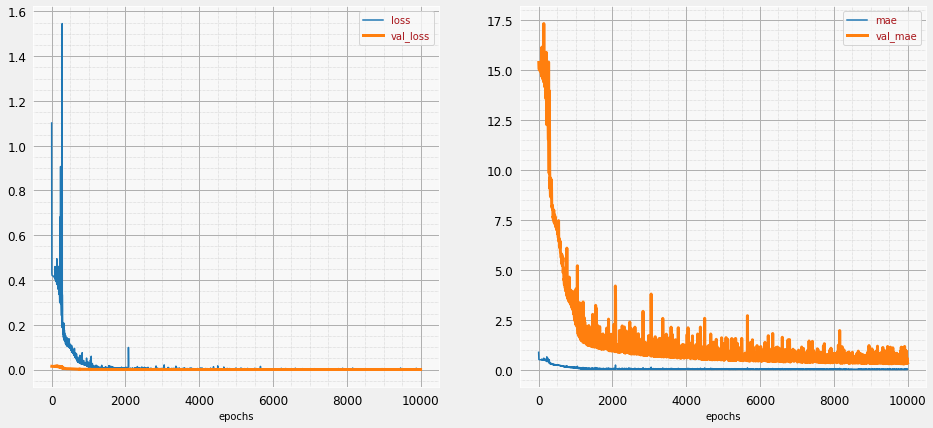

In [12]:
steps_per_epoch = train_size//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)


keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=50, verbose=0, 
                                        mode='auto', baseline=None, restore_best_weights=True)

history = network.fit(train_cord, train_label, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=(valid_cord, valid_label), validation_steps=steps_per_epoch, callbacks=[plot_training])


In [28]:
# for lay in network.layers:
#     print(lay.name)
#     print(lay.get_weights())

from __future__ import print_function

import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.

    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()

network.save_weights('my_model_weights.h5')
print_structure('my_model_weights.h5')

my_model_weights.h5 contains: 
Root attributes:
  backend: b'tensorflow'
  keras_version: b'2.3.1'
  layer_names: [b'dense_1' b'dense_2' b'dense_3' b'dense_4' b'dense_5' b'dense_6'
 b'dense_7' b'dense_8' b'dense_9' b'dense_10' b'dense_11' b'dense_12'
 b'dense_13']
  dense_1
    Attributes:
      weight_names: [b'dense_1/kernel:0' b'dense_1/bias:0']
    Dataset:
      dense_1/bias:0: [-0.06842873 -0.7557408  -0.69531745 -0.26648536  0.02282048  0.47315612
  0.19704634 -0.47443905 -0.10314704  0.0894416   0.15378399  0.22396854
 -0.9091439  -0.10413257  0.10435523 -0.09533893 -0.2294621   0.21336736
 -0.22103122  0.6571369  -0.12089605  0.07490054 -0.3053415   0.3729802
 -0.41336444 -0.26220286 -0.37651935 -0.6943084   0.06862424 -0.13825962
 -0.01559721 -0.39844772 -0.36006805  0.4849057   0.14348091 -0.852319
 -0.49139816 -0.06815358 -0.25144526 -0.1808395 ]
      dense_1/kernel:0: [[-2.86507607e-01  1.22240162e+00 -6.16135418e-01 -4.44101751e-01
  -1.83244944e-01 -9.30032194e-01  2.61

In [17]:

train_pred = network.predict(train_cord)
valid_pred = network.predict(valid_cord)

train_pred_inverse = scaler.inverse_transform(train_pred) / num
valid_pred_inverse = scaler.inverse_transform(valid_pred) / num

# train_pred_inverse = np.exp(train_pred) / num
# valid_pred_inverse = np.exp(valid_pred) / num

# print(train_pred_inverse[0:100])
print(df[0:10])
print(train_pred_inverse[0:10])

        0       1       2          3             4
0  0.7500  0.2500  0.7500  30.000000  2.282220e-06
1  0.2500  0.7500  0.2500  63.333332  1.230000e-12
2  0.3750  0.3750  0.6250  21.666666  8.339920e-07
3  0.8750  0.8750  0.1250  54.999996  6.737320e-06
4  0.6250  0.1250  0.3750  38.333332  8.504600e-10
5  0.1250  0.6250  0.8750  71.666664  1.200000e-13
6  0.1875  0.3125  0.3125  59.166664  4.600000e-13
7  0.6875  0.8125  0.8125  25.833332  2.523430e-05
8  0.4375  0.5625  0.0625  42.500000  3.450000e-12
9  0.3125  0.1875  0.9375  50.833332  6.871540e-09
[[2.3882940e-06]
 [1.1265264e-12]
 [8.9431398e-07]
 [5.9720437e-06]
 [7.5887385e-10]
 [1.1668922e-13]
 [4.2048271e-13]
 [2.3056786e-05]
 [3.1374055e-12]
 [6.4788002e-09]]


In [18]:
df3 = pd.DataFrame(np.vstack([train_pred_inverse,valid_pred_inverse]))
df3.to_csv('repulsion_total_pred_inverse.csv', index=False, header=False)